In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 16}
matplotlib.rc('font', **font)

import sqlite3
import pandas as pd
from src import clean_data as d
conn = sqlite3.connect('data/billboard-200.db')

In [2]:
albums_table, albums, artists, songs = d.get()
song_parameters = d.song_parameters
normal_parameters = d.normal_parameters

In [3]:
def weighted_score(param, chart):
    power_rank_col = chart['power']
    param_col = chart[param]
    return (power_rank_col * param_col).sum() / power_rank_col.sum()

def vibe(chart, params = song_parameters):
        return {p:weighted_score(p, chart) for p in params}

In [4]:
weekly_charts = albums_table.merge(albums, 
                                   on=['album','artist'], 
                                   how='left'
                                  ).groupby('date')

week_dates = weekly_charts.groups
week_scores = [vibe(chart) for _, chart in weekly_charts]

# Timeseries containing the scores for every week
parameter_ts = pd.DataFrame(week_scores, index=week_dates)

In [7]:
weekly_charts = albums_table.merge(albums, 
                                   on=['album','artist'], 
                                   how='left'
                                  ).groupby('date')

# Timeseries containing the scores for every week
parameter_ts = weekly_charts.agg(vibe)

KeyError: 'power'

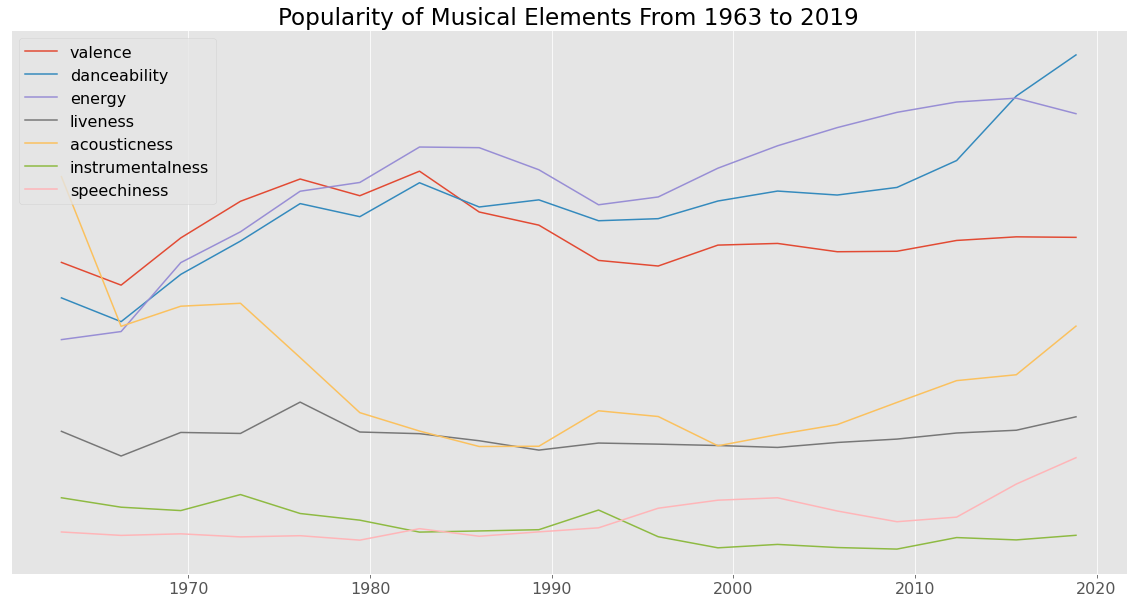

In [5]:
# Resample timeseries by every 1200 days to smooth out noise
resampled = parameter_ts.resample(pd.Timedelta(1200,'day')).mean()
fig, ax = plt.subplots(figsize=(20,10))
for p in normal_parameters:
    ax.plot(resampled.index, resampled[p])

ax.set_title('Popularity of Musical Elements From 1963 to 2019')
ax.set_ylabel('Popularity')
ax.get_yaxis().set_visible(False)
ax.legend(normal_parameters);

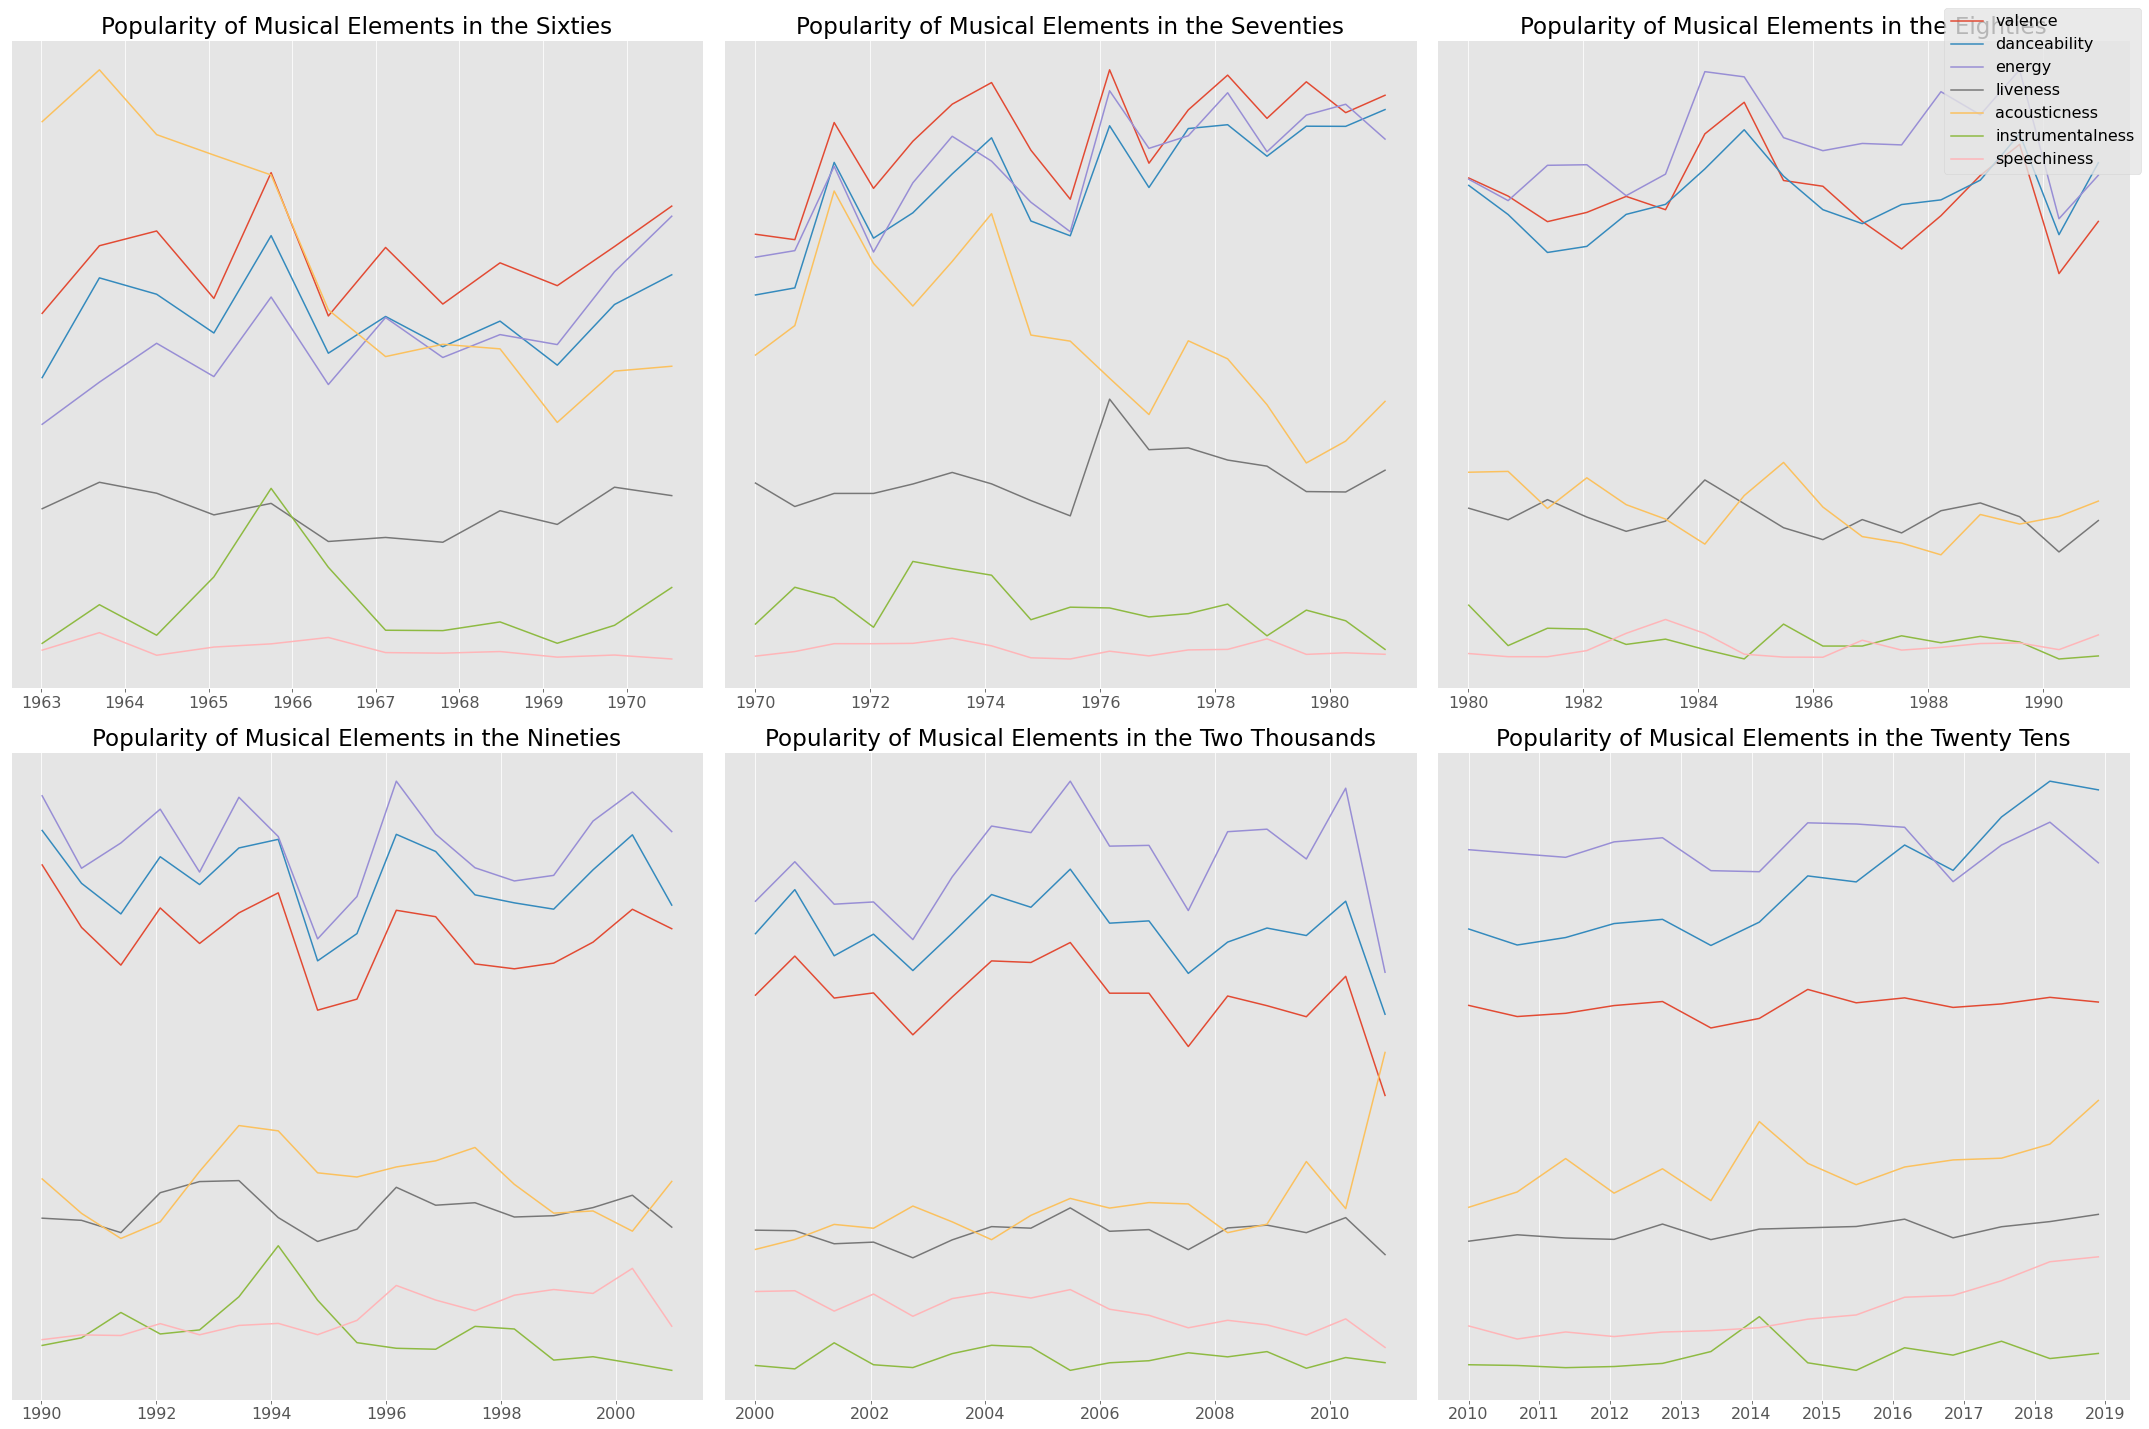

In [6]:
delta = pd.Timedelta(250,'day')

sixties       = parameter_ts.loc['1960':'1970'].resample(delta).mean()
seventies     = parameter_ts.loc['1970':'1980'].resample(delta).mean()
eighties      = parameter_ts.loc['1980':'1990'].resample(delta).mean()
nineties      = parameter_ts.loc['1990':'2000'].resample(delta).mean()
two_thousands = parameter_ts.loc['2000':'2010'].resample(delta).mean()
twenty_tens   = parameter_ts.loc['2010':'2020'].resample(delta).mean()

decade_ts = [sixties,
           seventies,
           eighties,
           nineties,
           two_thousands,
           twenty_tens]

decade_names = ['Sixties',
                'Seventies',
                'Eighties',
                'Nineties',
                'Two Thousands',
                'Twenty Tens']

fig, ax = plt.subplots(2, 3, figsize=(30,20))
for a, name, ts in zip(ax.flatten(), decade_names, decade_ts):
    for p in normal_parameters:
        a.plot(ts.index, ts[p])

    a.set_title(f'Popularity of Musical Elements in the {name}')
    a.set_ylabel('Popularity')
    a.get_yaxis().set_visible(False)

fig.legend(normal_parameters)
fig.tight_layout();